<a href="https://colab.research.google.com/github/profshai/neural-networks-deep-learning/blob/main/stacked_lstm_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Forecasting using Stacked Long Short Term Memory (LSTM) Networks

Dataset: Apple stock data from May 27, 2015 to May 22, 2020.

### Import Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [ ]:
df.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


We need the 'close' values

In [ ]:
df = df.reset_index()['close']
df.head()

0    132.045
1    131.780
2    130.280
3    130.535
4    129.960
Name: close, dtype: float64

In [ ]:
df.shape

(1258,)

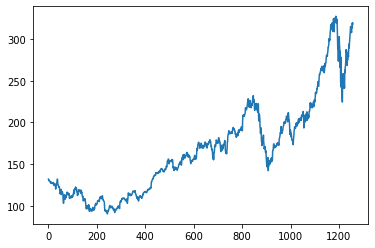

In [ ]:
plt.plot(df)

### Feature scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
df

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [ ]:
df.shape

(1258, 1)

### Split data into test and train set

In [ ]:
training_size = int(len(df) * 0.7)
train_data = df[0:training_size, :]
test_data = df[training_size: len(df), :]

In [ ]:
train_data.shape

(880, 1)

In [ ]:
test_data.shape

(378, 1)

In [ ]:
# convert an array of values into a dataset matrix
# To calculate the next value, we need the previous values (features)
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(779, 100)
(779,)


(None, None)

In [ ]:
print(X_test.shape), print(y_test.shape)

(277, 100)
(277,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Create Stacked LSTM Networks Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 10s 317ms/step - loss: 0.0305 - val_loss: 0.0327
Epoch 2/100
13/13 [==============================] - 3s 210ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 3/100
13/13 [==============================] - 3s 212ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 4/100
13/13 [==============================] - 3s 228ms/step - loss: 9.2467e-04 - val_loss: 0.0056
Epoch 5/100
13/13 [==============================] - 3s 226ms/step - loss: 7.5077e-04 - val_loss: 0.0066
Epoch 6/100
13/13 [==============================] - 3s 215ms/step - loss: 7.9418e-04 - val_loss: 0.0049
Epoch 7/100
13/13 [==============================] - 3s 210ms/step - loss: 7.0522e-04 - val_loss: 0.0047
Epoch 8/100
13/13 [==============================] - 3s 211ms/step - loss: 6.9421e-04 - val_loss: 0.0043
Epoch 9/100
13/13 [==============================] - 3s 209ms/step - loss: 6.5574e-04 - val_loss: 0.0048
Epoch 10/100
13/13 [==============================] - 3s 203ms/ste

### Prediction and Model performance

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Train data RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

149.66750266673492

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

245.63687792421226

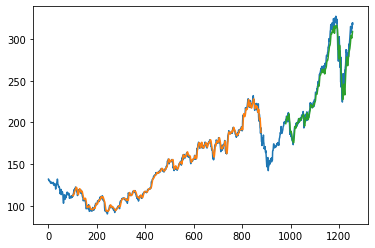

In [ ]:
### Plottin 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

378

In [ ]:
x_input=test_data[278:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# temp_input

In [ ]:
# Prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
# print(lst_output)

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df)

1258

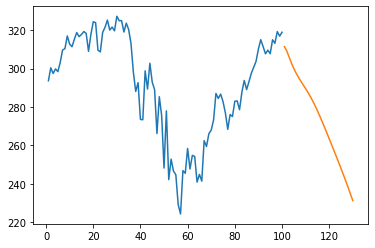

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

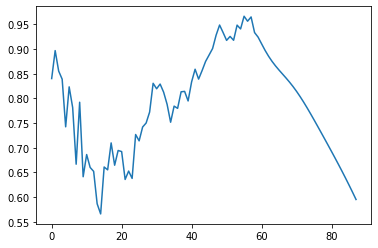

In [ ]:
df3=df.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

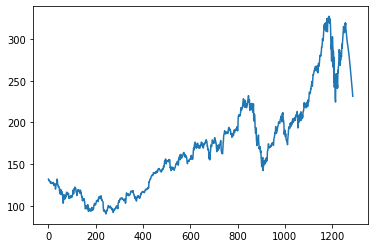

In [ ]:
plt.plot(df3)

End of Notebook!